In [23]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from datetime import datetime
import re
from textblob import TextBlob
from nltk.translate.bleu_score import sentence_bleu
from transformers import DistilBertModel,DistilBertTokenizer
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer
from tqdm import tqdm

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
df = pd.read_csv("data/combined/filtered_combined.csv", index_col = 0)


In [3]:
df.reset_index(inplace=True)
df.drop(columns="index",inplace=True)

# Objectives
1. calculate sentiment using transformers sentiment analysis for all sentences
2. calculate sentiment difference
3. calculate BLEU scores (edit: we can also consider ROUGE or any other method that is token-based)
4. look for sentiment distributions in cases where:
    - BLEU score is very high
    - BLEU score is very high AND labels are low 
        - seperate distribution into labelers 

In [37]:
# Sentiment analysis pipeline
sentiment_pipe = pipeline("sentiment-analysis", device = 0)


In [54]:
from tqdm import tqdm

text1_sent,text2_sent =[], []

pbar = tqdm(total = len(df)//100+1, position = 0, leave = True)
for i in range (len(df)//100+1):
    t1_s = sentiment_pipe(df.text1.tolist()[100*i:np.min([100*i+100,len(df)])])
    t2_s = sentiment_pipe(df.text2.tolist()[100*i:np.min([100*i+100,len(df)])])
    text1_sent+=t1_s
    text2_sent+=t2_s
    pbar.update()
pbar.close()
len(text1_sent)

100%|██████████| 304/304 [04:25<00:00,  1.14it/s]


30301

In [61]:
sent = {'POSITIVE':1,'NEGATIVE':-1}

df['sentiment_1'] = np.array([x['score']*sent[x['label']] for x in text1_sent]) 
df['sentiment_2'] = np.array([x['score']*sent[x['label']] for x in text2_sent])
df['dif_sent'] =  np.abs(df['sentiment_1']-df['sentiment_2'])

count    30301.000000
mean         0.694073
std          0.895343
min          0.000000
25%          0.003608
50%          0.040594
75%          1.917448
max          1.999704
Name: dif_sent, dtype: float64

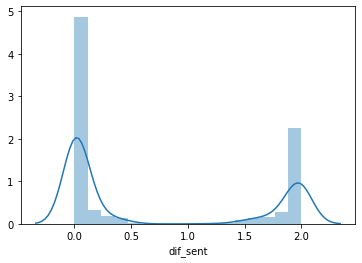

In [63]:


sns.distplot(df.dif_sent);
df.dif_sent.describe()

In [76]:
len(df.dif_sent[(df.dif_sent>.5) & (df.dif_sent<1.5)])

231

we can see that there isn't much ambiguity regarding the sentiment similarity. the sentences are either similar ( around 0 diff) or dissimialr (around 2 diff). <br>
only 231 (0.7%) sentences pairs have some ambiguity to them (0.5<diff<1.5)

In [4]:
df.head(5)

,annotator,text1,text2,label,dataset,random,duration,total_seconds,pair_id,reduced_label,radical,radical_mean,radical_random,radical_non_random,is_radical,is_centralist,sentiment_1,sentiment_2,dif_sent,bleu_score_1
0,A3SQ00HYQN7FYB,"And he sent Eliakim , who was over the househo...","And he sent Eliakim , who was over the house ,...",3,bible_human,0,0 days 00:00:12.000000000,12,pair_0,0,0,-0.222222,-0.059701,-0.348837,False,True,-0.970466,0.556437,1.526903,0.777466
1,A168NGIUW93RV5,"The word of the Lord which came to Joel , the ...",The word of the Lord that came to Joel the son...,4,bible_human,0,0 days 00:00:20.000000000,20,pair_3,1,-1,-0.184211,-0.090226,-0.244019,False,True,0.956103,0.952563,0.003540,0.798054
2,A2Z5WHZ0A2JJ6A,"Adam , Seth , Enosh ,","Adam , Seth , Enosh ,",5,bible_human,0,0 days 00:00:13.000000000,13,pair_4,1,1,0.559140,0.815789,0.381818,False,False,0.997491,0.997491,0.000000,1.000000
3,A351BKQC7NEH3A,"Adam , Seth , Enosh ,","Adam , Seth , Enosh ,",5,bible_human,0,0 days 00:00:06.000000000,6,pair_4,1,1,0.000000,NaN,0.000000,False,False,0.997491,0.997491,0.000000,1.000000
4,AE7UECBR4D5E6,having become by so much better than the angel...,taking a place by so much better than the ange...,3,bible_human,0,0 days 00:00:14.000000000,14,pair_5,0,0,-0.216066,-0.253333,-0.189573,False,True,0.995914,0.998988,0.003074,0.809524


In [5]:
pairs = []
for index, row in df.iterrows():
    first_sentence_tokens = row['text1'].strip().split()
    second_sentence_tokens = row['text2'].strip().split()
    pairs.append((first_sentence_tokens, second_sentence_tokens))

In [72]:
scores_bleu1 = []
for first_sentence_tokens, second_sentence_tokens in pairs:

    score_bleu1 = sentence_bleu([first_sentence_tokens], second_sentence_tokens, weights=(1, 0, 0, 0))
    scores_bleu1.append(score_bleu1)

print(np.mean(scores_bleu1))
print(np.std(scores_bleu1))



0.3019563429648848
0.26047234907647265


In [73]:
df['bleu_score_1'] = scores_bleu1

In [102]:
df.to_csv("data/combined/filtered_combined.csv")


# Saved data with new features, let's analyze

count    30301.000000
mean         0.301956
std          0.260477
min          0.000000
25%          0.083333
50%          0.222222
75%          0.500000
max          1.000000
Name: bleu_score_1, dtype: float64


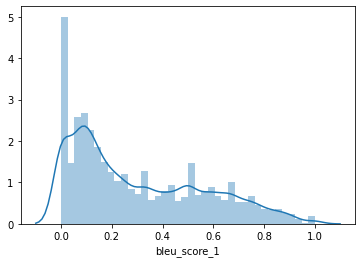

In [75]:
print(df.bleu_score_1.describe())
sns.distplot(df.bleu_score_1);

In [6]:
df.loc[df['bleu_score_1'] > 0.8]

,annotator,text1,text2,label,dataset,random,duration,total_seconds,pair_id,reduced_label,radical,radical_mean,radical_random,radical_non_random,is_radical,is_centralist,sentiment_1,sentiment_2,dif_sent,bleu_score_1
2,A2Z5WHZ0A2JJ6A,"Adam , Seth , Enosh ,","Adam , Seth , Enosh ,",5,bible_human,0,0 days 00:00:13.000000000,13,pair_4,1,1,0.559140,0.815789,0.381818,False,False,0.997491,0.997491,0.000000,1.000000
3,A351BKQC7NEH3A,"Adam , Seth , Enosh ,","Adam , Seth , Enosh ,",5,bible_human,0,0 days 00:00:06.000000000,6,pair_4,1,1,0.000000,NaN,0.000000,False,False,0.997491,0.997491,0.000000,1.000000
4,AE7UECBR4D5E6,having become by so much better than the angel...,taking a place by so much better than the ange...,3,bible_human,0,0 days 00:00:14.000000000,14,pair_5,0,0,-0.216066,-0.253333,-0.189573,False,True,0.995914,0.998988,0.003074,0.809524
5,A3S104I5V53HB8,having become by so much better than the angel...,taking a place by so much better than the ange...,4,bible_human,0,0 days 00:00:05.000000000,5,pair_5,1,-1,-0.300000,-0.148148,-0.615385,False,True,0.995914,0.998988,0.003074,0.809524
6,A1GZZGA7ZFUPMB,"When therefore he was gone out , Jesus saith ,...","When therefore he was gone out Jesus says , No...",3,bible_human,0,0 days 00:00:42.000000000,42,pair_6,0,0,-0.428571,NaN,-0.428571,False,True,0.801000,0.736528,0.064472,0.879257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27962,AG7G6ZGG73JP7,the salsa was fantastic although next time i w...,the salsa was horrible although next time i wi...,1,yelp_human,0,0 days 00:00:18.000000000,18,pair_12215,-1,1,0.783465,0.898089,0.597938,True,False,0.999529,-0.999126,1.998655,0.933333
27963,A1SK0GV4SSOH1A,the salsa was fantastic although next time i w...,the salsa was horrible although next time i wi...,1,yelp_human,0,0 days 00:00:20.000000000,20,pair_12215,-1,1,0.156627,0.177291,0.131387,False,False,0.999529,-0.999126,1.998655,0.933333
27964,A1PR75OOJOLBA2,the salsa was fantastic although next time i w...,the salsa was horrible although next time i wi...,2,yelp_human,0,0 days 00:00:09.000000000,9,pair_12215,-1,-1,-0.362916,-0.374456,-0.349040,False,True,0.999529,-0.999126,1.998655,0.933333
27967,A2B6IFOZY2D4A4,this was the first time i ever cried from a ha...,this was the first time i ever cried of happin...,4,yelp_human,0,0 days 00:00:08.000000000,8,pair_12217,1,-1,0.388889,0.503171,0.287850,False,False,-0.711496,0.998174,1.709671,0.846154


count    1276.000000
mean        3.718652
std         1.453595
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: label, dtype: float64

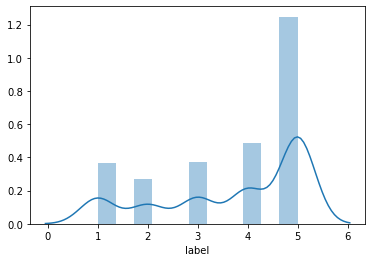

In [32]:
high_bleu1 = df[(df['bleu_score_1'] > 0.8)]
sns.distplot(high_bleu1.label);
high_bleu1.label.describe()

In [44]:
i=np.random.choice(len(high_bleu1[high_bleu1.label<3]))
print(high_bleu1[high_bleu1.label<3].text1.iloc[i])
print(high_bleu1[high_bleu1.label<3].text2.iloc[i])
print(high_bleu1[high_bleu1.label<3].label.iloc[i])

no wonder these restaurants are closing up all around the valley .
no wonder these restaurants are n't closing up all around the valley .
2


In [45]:
i=np.random.choice(len(high_bleu1[high_bleu1.label<3]))
print(high_bleu1[high_bleu1.label<3].text1.iloc[i])
print(high_bleu1[high_bleu1.label<3].text2.iloc[i])
print(high_bleu1[high_bleu1.label<3].label.iloc[i])

she was absolutely fantastic and i love what she did !
she was absolutely awful and i hate what she did !
1


In [46]:
i=np.random.choice(len(high_bleu1[high_bleu1.label<3]))
print(high_bleu1[high_bleu1.label<3].text1.iloc[i])
print(high_bleu1[high_bleu1.label<3].text2.iloc[i])
print(high_bleu1[high_bleu1.label<3].label.iloc[i])

i 'd definitely recommend giving them a try .
i 'd definitely recommend not giving them a try .
2


Now let's review what happens when we take sentiment into account

count    870.000000
mean       4.085057
std        1.247186
min        1.000000
25%        3.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: label, dtype: float64
correlation between BLEU1 scores and labels when sentiment is similar:0.08599608230900761
.32 kilometer equal how many centimeter ?
how many centimeter equal one kilometer ?
1


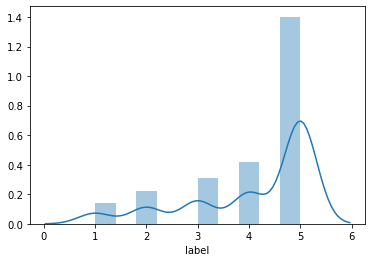

In [60]:
same_sent = high_bleu1[high_bleu1.dif_sent<1]
sns.distplot(same_sent.label), print(same_sent.label.describe())
i = np.random.choice(len(same_sent[same_sent.label<3]))
print(same_sent[same_sent.label<3].text1.iloc[i])
print(same_sent[same_sent.label<3].text2.iloc[i])
print(same_sent[same_sent.label<3].label.iloc[i])

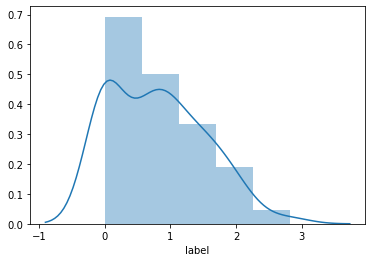

In [59]:
sns.distplot(dif_sent.groupby('annotator')['label'].std());

There are some outliers of lazy labeling, but the overwhelming majority of sentences pairs (75%) are above label 3

In [54]:
dif_sent = high_bleu1[high_bleu1.dif_sent>1.5]

labels stantard deviation:1.54


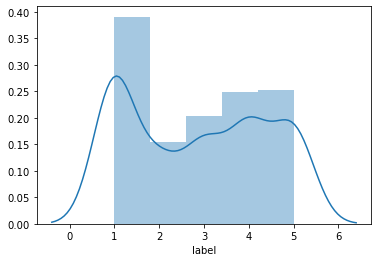

In [66]:
sns.distplot(dif_sent.label); print(f'labels stantard deviation:{np.round(dif_sent.label.std(),2)}')

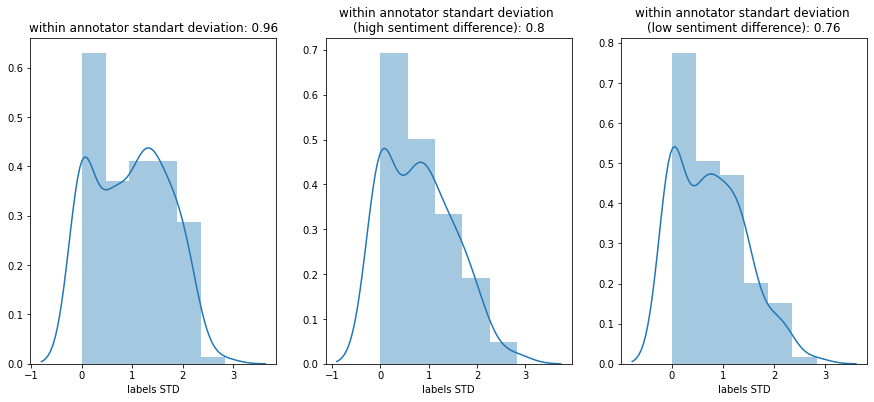

In [87]:
f,ax =  plt.subplots(figsize = (15,6))
ax = plt.subplot(1,3,1)
ax = sns.distplot(high_bleu1.groupby('annotator')['label'].std());
plt.xlabel('labels STD');
plt.title('within annotator standart deviation: {}'.format(np.round(high_bleu1.groupby('annotator')['label'].std().mean(),2)));

ax = plt.subplot(1,3,2)
ax = sns.distplot(dif_sent.groupby('annotator')['label'].std());
plt.title('within annotator standart deviation \n(different sentiment): {}'.format(np.round(dif_sent.groupby('annotator')['label'].std().mean(),2)));
plt.xlabel('labels STD');

ax = plt.subplot(1,3,3)
ax = sns.distplot(same_sent.groupby('annotator')['label'].std());
plt.title('within annotator standart deviation \n(same sentiment): {}'.format(np.round(same_sent.groupby('annotator')['label'].std().mean(),2)));
plt.xlabel('labels STD');

# Conclusions
1. When the expressed sentiment in senteneces are similar, labels tend to cluster on the high end of the scale, evident by high mean and median and low std of the labels. meaning that there is very little place for confusion that sentences are in fact similar.
2. when sentences express different sentiment things get more tricky, labels scatter all over the scale and BLEU1 scores stop being a reliable predictor of sematic similarity labels:
    - distribution form of labels turns into more of a uniform instead of linear
    - within annotators std. is lower when classifying according to sentiment
3. these finding support the assumption that different actors give different weight to the role of sentiment in distinguishing semantic similarity. <br>
Moreover, when controled for high sentiment similarity, we found that high BLEU1 scores are predictors of similarity.  
    